In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('drive/My Drive/Colab Notebooks/AI RESIDENCY/P4')

Mounted at /content/drive


In [ ]:
import torchvision
from torchvision import datasets
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import *
from torchsummary import summary
from torch import nn, optim

import numpy as np

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
## !pip install split-folders
## import splitfolders
## splitfolders.ratio('training', output='drive/My Drive/Colab Notebooks/AI RESIDENCY/P4', ratio=(.8, 0.2)) 

In [ ]:
## Data Augmentation
train_transform = transforms.Compose([
    transforms.CenterCrop(1080),
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(p=.5),
    transforms.RandomVerticalFlip(p=.5),
    transforms.RandomRotation(degrees=(30, 70)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5])])

valid_transform = transforms.Compose([
    transforms.CenterCrop(1080),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5])])

test_transform = transforms.Compose([
    transforms.CenterCrop(1080),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5])])

In [ ]:
## Load the data
data_dir = "/content/drive/MyDrive/Colab Notebooks/AI RESIDENCY/P4/"

d_train = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                               transform = train_transform)

d_val = datasets.ImageFolder(os.path.join(data_dir, 'val'),
                               transform = valid_transform)

d_test = datasets.ImageFolder(os.path.join(data_dir, 'testing'),
                              transform = test_transform)



## DataLoaders
dl_train = DataLoader(dataset=d_train,
                batch_size=16,
                shuffle=True, 
                drop_last=False)

dl_valid = DataLoader(dataset=d_val,
                      batch_size=5,
                      shuffle=True)

dl_test = DataLoader(dataset=d_test)

In [ ]:
print('Training dataset:')
print('-------------------')
print(f"Classes: {d_train.classes}")
print(f"Class count: {d_train.targets.count(0)}, {d_train.targets.count(1)}")
print(f"Samples:",len(d_train))
print()

print('Validation dataset:')
print('-------------------')
print(f"Classes: {d_val.classes}")
print(f"Class count: {d_val.targets.count(0)}, {d_val.targets.count(1)}")
print(f"Samples:",len(d_val))

print()
print('Test dataset:')
print('------------------')
print(f"Classes: {d_test.classes}")
print(f"Class count: {d_test.targets.count(0)}, {d_test.targets.count(1)}")
print(f"Samples:",len(d_test))

Training dataset:
-------------------
Classes: ['flip', 'notflip']
Class count: 929, 984
Samples: 1913

Validation dataset:
-------------------
Classes: ['flip', 'notflip']
Class count: 233, 246
Samples: 479

Test dataset:
------------------
Classes: ['flip', 'notflip']
Class count: 243, 307
Samples: 550


In [ ]:
inputs, classes = next(iter(dl_train))

In [ ]:
print(f'Batch size: {inputs.shape[0]}')
print(f'Number of color channels: {inputs.shape[1]}')
print(f'Image size: {inputs.shape[2]} x {inputs.shape[3]}')

Batch size: 16
Number of color channels: 3
Image size: 224 x 224


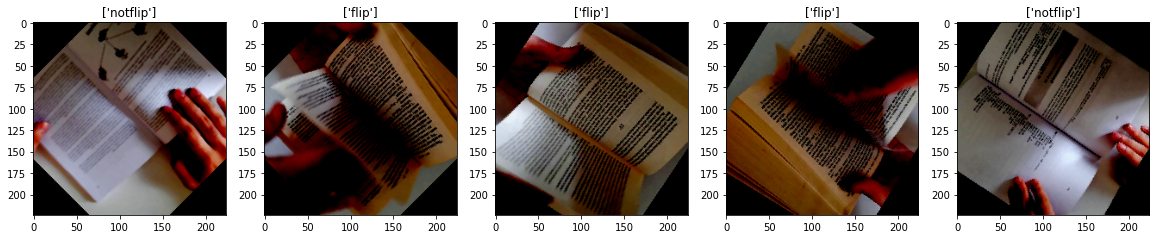

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(inputs[i].permute(1, 2, 0))
    plt.title([d_train.classes[classes[i]]])

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            ## block 1
            nn.Conv2d(in_channels=3, out_channels=64,
                      kernel_size=(3, 3)),  ## Convo layer

            nn.ReLU(),                      ## ReLU activation function
            nn.MaxPool2d((2, 2)),           ## Pooling layer
            nn.Dropout(p=.2),               ## Dropout layer

            ## block 2
            nn.Conv2d(64, 32, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout(p=.2),
            ## block 3
            nn.Conv2d(32, 16, (2,2)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(p=.2),
             
            nn.Flatten(),
            nn.Linear(10816, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64,1))

    def forward(self, x):
        out = torch.sigmoid(self.main(x)) ## sigmoid as we will use the BCELoss loss function
        return out

In [ ]:
model = Net()
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 222, 222]           1,792
              ReLU-2         [-1, 64, 222, 222]               0
         MaxPool2d-3         [-1, 64, 111, 111]               0
           Dropout-4         [-1, 64, 111, 111]               0
            Conv2d-5         [-1, 32, 109, 109]          18,464
              ReLU-6         [-1, 32, 109, 109]               0
         MaxPool2d-7           [-1, 32, 54, 54]               0
           Dropout-8           [-1, 32, 54, 54]               0
            Conv2d-9           [-1, 16, 53, 53]           2,064
             ReLU-10           [-1, 16, 53, 53]               0
        MaxPool2d-11           [-1, 16, 26, 26]               0
          Dropout-12           [-1, 16, 26, 26]               0
          Flatten-13                [-1, 10816]               0
           Linear-14                 [-

In [ ]:
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()
optim_adam = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
## Ref: https://github.com/Bjarten/early-stopping-pytorch
## import EarlyStopping
from pytorchtools import EarlyStopping

In [ ]:
def train_model(model, criterion, optimizer, trainloader, valloader, epochs=5, patience=2, verbose=True):
    
    train_loss, train_accuracy = [], []
    val_loss = []
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        train_batch_acc = 0
        val_batch_loss = 0
        

        # Training
        model.train()
        for X, y in trainloader:
            ## reset the gradient
            optimizer.zero_grad()
            ## forward pass
            y_hat = model(X).flatten()
            ## calculate the loss
            loss = criterion(y_hat, y.type(torch.float32))
            ## backpropagation
            loss.backward()
            ## update the weights
            optimizer.step()
            train_batch_loss += loss.item()
            train_batch_acc += (torch.round(y_hat) == y).type(torch.float32).mean().item()
        train_loss.append(train_batch_loss / len(trainloader))
        train_accuracy.append(train_batch_acc / len(trainloader))
        
        
        # Validation
        model.eval()
        for data, target in valloader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data).flatten()
            # calculate the loss
            loss = criterion(output, target.type(torch.float32))
            val_batch_loss += loss.item()

        ## record validation loss
        val_loss.append(val_batch_loss / len(valloader))
        

        ## Print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Loss: {train_loss[-1]:.3f}",
                  f"Train Accuracy: {train_accuracy[-1]:.2f}",
                  f"Validation Loss: {val_loss[-1]:.3f}")
            
        
        ## early_stopping needs the validation loss to check if it has decresed, 
        ## and if it has, it will make a checkpoint of the current model
        val_loss_arr = np.average(val_loss)
        early_stopping(val_loss_arr, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break

       
    results = {"train_loss": train_loss,
               "train_accuracy": train_accuracy,
               "val_loss": val_loss}
   
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return results, train_loss, train_accuracy, val_loss

In [ ]:
#results, train_loss, train_accuracy, val_loss = train_model(model, criterion, optim_adam, dl_train, dl_valid, epochs=10)

Epoch 1: Train Loss: 0.577 Train Accuracy: 0.68 Validation Loss: 0.513
Validation loss decreased (inf --> 0.513455).  Saving model ...
Epoch 2: Train Loss: 0.383 Train Accuracy: 0.84 Validation Loss: 0.432
Validation loss decreased (0.513455 --> 0.472696).  Saving model ...
Epoch 3: Train Loss: 0.279 Train Accuracy: 0.88 Validation Loss: 0.400
Validation loss decreased (0.472696 --> 0.448535).  Saving model ...
Epoch 4: Train Loss: 0.221 Train Accuracy: 0.91 Validation Loss: 0.437
Validation loss decreased (0.448535 --> 0.445768).  Saving model ...
Epoch 5: Train Loss: 0.202 Train Accuracy: 0.92 Validation Loss: 0.552
EarlyStopping counter: 1 out of 2
Epoch 6: Train Loss: 0.143 Train Accuracy: 0.94 Validation Loss: 0.455
EarlyStopping counter: 2 out of 2
Early stopping


In [ ]:
## save the model
#torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/AI RESIDENCY/P4/model.ckpt")

In [ ]:
## load the model
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/AI RESIDENCY/P4/model.ckpt"))

<All keys matched successfully>

In [ ]:
def test_model(model, criterion, testloader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for X, y in testloader:
      out = model(X).flatten()
      test_loss += criterion(out, y.type(torch.float32))
      correct += torch.round(out).eq(y).sum()
    
    test_loss /= len(testloader)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(testloader),
            100. * correct / len(testloader)))

In [ ]:
test_model(model, criterion, dl_test)


Test set: Avg. loss: 0.4933, Accuracy: 461/550 (84%)



In [ ]:
#np.save('train_loss.npy', np.array(train_loss))
#np.save('train_accuracy.npy', np.array(train_accuracy))

train_loss = np.load('train_loss.npy')
train_accuracy = np.load('train_accuracy.npy')

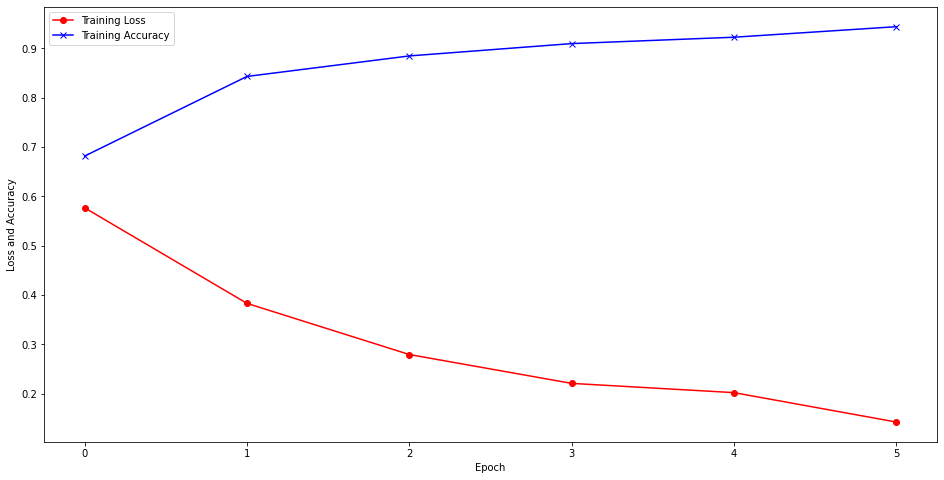

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(train_loss,color="r",marker="o")
plt.plot(train_accuracy, color='b', marker='x')

plt.xlabel("Epoch")
plt.ylabel("Loss and Accuracy")
plt.legend(["Training Loss", "Training Accuracy"])
plt.show()

In [ ]:
from sklearn.metrics import classification_report

dl_test_ = DataLoader(dataset=d_test,
                      batch_size=1)

def test_model_batch_size1(model, criterion, testloader):
  model.eval()
  test_loss, correct = 0, 0
  pred_list, true_list = [], []

  with torch.no_grad():
    for X, y in testloader:
      out = model(X).flatten()
      test_loss += criterion(out, y.type(torch.float32))
      correct += torch.round(out).eq(y.type(torch.float32)).sum()
      pred_list.append(torch.round(out))
      true_list.append(y.type(torch.float32))
      
    test_loss /= len(testloader)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(testloader),
            100. * correct / len(testloader)))
    
  return pred_list, true_list

In [ ]:
predictions, labels = test_model_batch_size1(model, criterion, dl_test_)


Test set: Avg. loss: 0.4933, Accuracy: 461/550 (84%)



In [ ]:
print(classification_report([i.item() for i in predictions], [i.item() for i in labels]))

              precision    recall  f1-score   support

         0.0       0.71      0.91      0.79       190
         1.0       0.94      0.80      0.87       360

    accuracy                           0.84       550
   macro avg       0.82      0.85      0.83       550
weighted avg       0.86      0.84      0.84       550



In [ ]:
## transfer learning

In [ ]:
!pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=a50caa0abbdb0fc51dcffff7501c664f698105f3fccf5050c7368b62049255d6
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
Successfully built efficientnet-pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet

In [ ]:
eff_model = EfficientNet.from_pretrained('efficientnet-b4')

Loaded pretrained weights for efficientnet-b4


In [ ]:
eff_model

In [ ]:
class Efficient(nn.Module):
    def __init__(self):
        super(Efficient, self).__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b4')
        
        self.out = nn.Sequential(
                  nn.Linear(in_features = 1000, out_features = 512), 
                  nn.ReLU(), 
                  nn.Dropout(p=0.2),
                  nn.Linear(in_features = 512, out_features = 1),
)
        
    def forward(self, x):
        x = self.model(x)
        return torch.sigmoid(self.out(x))

In [ ]:
efficient_model = Efficient()
summary(efficient_model,(3,224,224))

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth


  0%|          | 0.00/74.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b4
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 48, 112, 112]           1,296
       BatchNorm2d-3         [-1, 48, 112, 112]              96
MemoryEfficientSwish-4         [-1, 48, 112, 112]               0
         ZeroPad2d-5         [-1, 48, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 48, 112, 112]             432
       BatchNorm2d-7         [-1, 48, 112, 112]              96
MemoryEfficientSwish-8         [-1, 48, 112, 112]               0
          Identity-9             [-1, 48, 1, 1]               0
Conv2dStaticSamePadding-10             [-1, 12, 1, 1]             588
MemoryEfficientSwish-11             [-1, 12, 1, 1]               0
         Identity-12             [-1, 12, 1, 1]               0
Conv2dStaticSamePadding-13        

In [ ]:
eff_train_transform = transforms.Compose([
    transforms.CenterCrop(1080),
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(p=.5),
    transforms.RandomVerticalFlip(p=.5),
    transforms.RandomRotation(degrees=(30, 70)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

eff_valid_transform = transforms.Compose([
    transforms.CenterCrop(1080),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

eff_test_transform = transforms.Compose([
    transforms.CenterCrop(1080),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
data_dir = "/content/drive/MyDrive/Colab Notebooks/AI RESIDENCY/P4/"


eff_d_train = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                               transform = eff_train_transform)

eff_d_val = datasets.ImageFolder(os.path.join(data_dir, 'val'),
                               transform = eff_valid_transform)

eff_d_test = datasets.ImageFolder(os.path.join(data_dir, 'testing'),
                              transform = eff_test_transform)




eff_dl_train = DataLoader(dataset=eff_d_train,
                batch_size=16,
                shuffle=True, 
                drop_last=False)

eff_dl_valid = DataLoader(dataset=eff_d_val,
                      batch_size=5,
                      shuffle=True)

dl_test = DataLoader(dataset=eff_d_test)

In [ ]:
eff_criterion = nn.BCELoss()
eff_optim = optim.Adam(efficient_model.parameters(), lr=0.001)

In [ ]:
eff_results, eff_train_loss, eff_train_accuracy, eff_val_loss = train_model(efficient_model, eff_criterion, eff_optim, eff_dl_train, eff_dl_valid, epochs=10)

Epoch 1: Train Loss: 0.428 Train Accuracy: 0.82 Validation Loss: 0.521
Validation loss decreased (inf --> 0.520553).  Saving model ...
Epoch 2: Train Loss: 0.208 Train Accuracy: 0.93 Validation Loss: 0.696
EarlyStopping counter: 1 out of 5
Epoch 3: Train Loss: 0.163 Train Accuracy: 0.94 Validation Loss: 0.179
Validation loss decreased (0.520553 --> 0.465070).  Saving model ...
Epoch 4: Train Loss: 0.120 Train Accuracy: 0.96 Validation Loss: 0.428
Validation loss decreased (0.465070 --> 0.455688).  Saving model ...
Epoch 5: Train Loss: 0.109 Train Accuracy: 0.96 Validation Loss: 6.076
EarlyStopping counter: 1 out of 5
Epoch 6: Train Loss: 0.121 Train Accuracy: 0.96 Validation Loss: 1.213
EarlyStopping counter: 2 out of 5
Epoch 7: Train Loss: 0.156 Train Accuracy: 0.95 Validation Loss: 0.587
EarlyStopping counter: 3 out of 5
Epoch 8: Train Loss: 0.170 Train Accuracy: 0.96 Validation Loss: 1.619
EarlyStopping counter: 4 out of 5
Epoch 9: Train Loss: 0.077 Train Accuracy: 0.97 Validation L

In [ ]:
#save the model
torch.save(efficient_model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/AI RESIDENCY/P4/efficient_model.ckpt")

In [ ]:
efficient_model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/AI RESIDENCY/P4/efficient_model.ckpt"))

In [ ]:
test_model(efficient_model, eff_criterion, dl_test)


Test set: Avg. loss: 0.5113, Accuracy: 446/550 (81%)



In [ ]:
np.save('eff_train_loss.npy', np.array(eff_train_loss))
np.save('eff_train_accuracy.npy', np.array(eff_train_accuracy))
np.save('eff_val_loss.npy', np.array(eff_val_loss))


eff_train_loss = np.load('eff_train_loss.npy')
eff_train_accuracy = np.load('eff_train_accuracy.npy')
eff_val_loss = np.load('eff_val_loss.npy')

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(eff_train_loss,color="r",marker="o")
plt.plot(eff_train_accuracy, color='b', marker='x')

plt.xlabel("Epoch")
plt.ylabel("Loss and Accuracy")
plt.legend(["Training Loss", "Training Accuracy"])
plt.show()